# Portfolio Optimization

This [Jupyter notebook](http://jupyter.org/) demonstrates the formulation and solution of portfolio optimization problems.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# data wrangling libraries
import pandas_datareader.data as web
import pandas as pd
import datetime

## Load Price Data

Here we create several groups of possible trading symbols, and select one for study.

In [2]:
# Companies of the Dow Jones Industrial Average
djia = ['axp', 'aapl', 'amgn', 'ba', 'cat', 'crm', 'cvx', 'csco',  'dis', 'dow',
        'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'ko', 'mcd', 'mmm', 'mrk',
        'msft', 'nke', 'pg', 'trv', 'unh', 'vz', 'v', 'wba', 'wmt']

# Representative ETF's and ETN's from the energy sector
energy = ['uso', 'ung', 'tan', 'wndy', ]

# Standard indices
indices = ['^dji', '^gspc']

# pick one of these groups for study
symbols = djia[0:5]
#symbols = energy
print(symbols)

['axp', 'aapl', 'amgn', 'ba', 'cat']


Price data is retrieved using the Pandas DataReader function. The first price data set consists of historical data that will be used to design investment portfolios. The second set will be used for simulation and evaluation of resulting portfolios. The use of 'out-of-sample' data for evaluation is standard practice in these types of applications.

In [98]:
t2 = datetime.datetime.now()
t1 = t2 - datetime.timedelta(365)
t0 = t1 - datetime.timedelta(2*365)

prices = pd.DataFrame()
prices_test = pd.DataFrame()
for symbol in symbols:
    print(symbol, end='')
    for _ in range(3):
        try:
            prices[symbol] = web.DataReader(symbol, 'yahoo', t0, t1)["Adj Close"]
            prices_test[symbol] = web.DataReader(symbol, 'yahoo', t1, t2)["Adj Close"]
            print(' ok.', end="")
            break
        except:
            print(" fail. Try again.", end="")
    print()

axp ok.
aapl ok.
amgn ok.
ba ok.
cat ok.


## Plot Price and Returns Data

In [99]:
prices.head()

,axp,aapl,amgn,ba,cat
Date,,,,,
2019-12-04,113.070,64.105,214.000,346.777,130.179
2019-12-05,113.396,65.046,213.570,343.635,131.043
2019-12-06,115.629,66.302,213.900,351.996,132.594
2019-12-09,115.486,65.374,213.031,349.133,132.697
2019-12-10,115.907,65.756,213.964,345.842,132.734


<AxesSubplot:ylabel='Linear Daily Returns'>

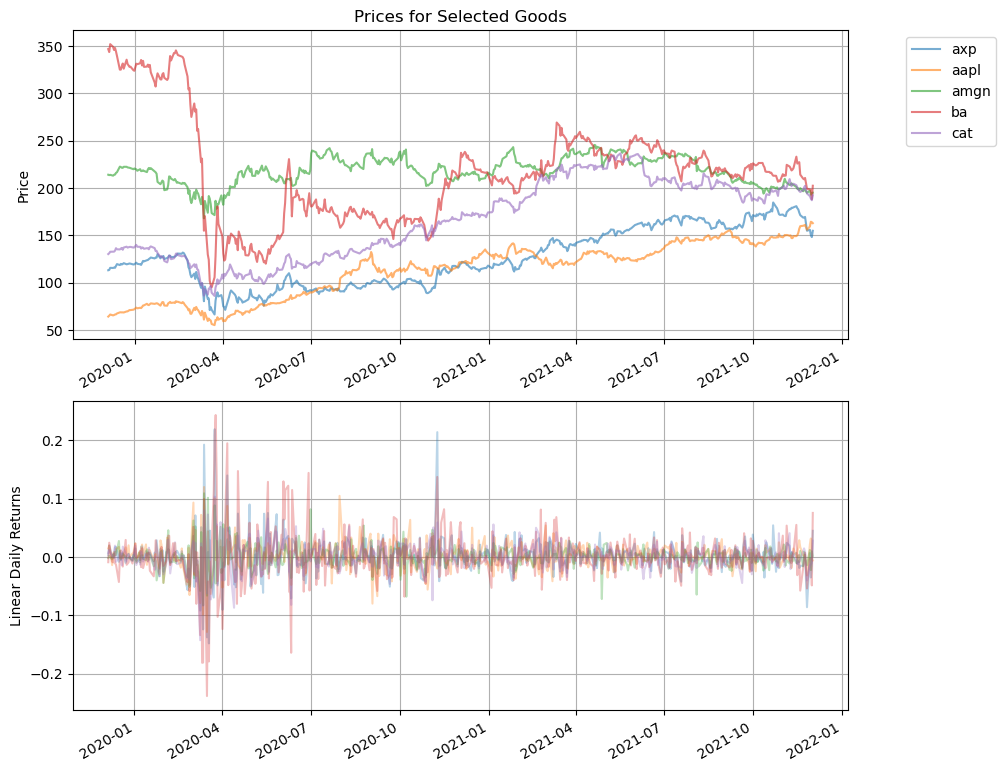

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
prices.plot(ax=ax[0], title='Prices for Selected Goods', xlabel="", ylabel="Price", grid=True, alpha=0.6)
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

returns = prices.diff()/prices.shift(1)
returns.plot(ax=ax[1], ylabel='Linear Daily Returns', xlabel="", grid=True, alpha=0.3, legend=False)

## Linear and Log Returns

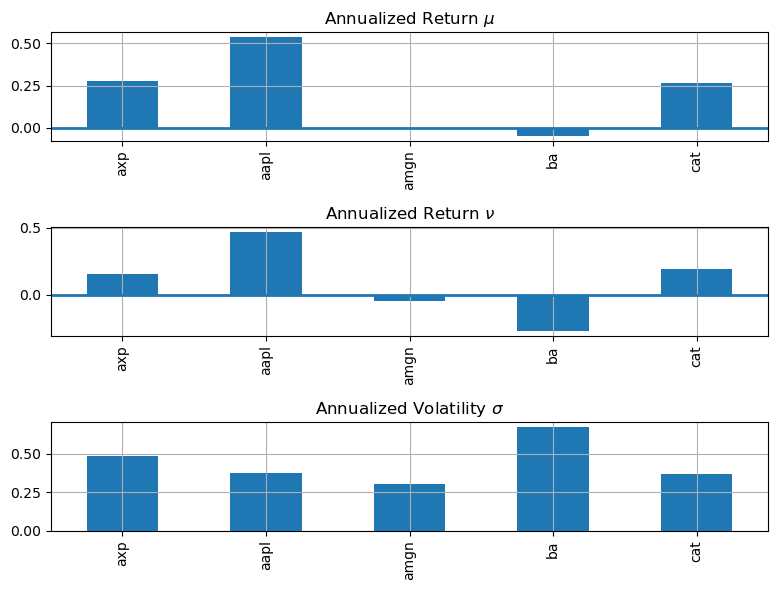

In [101]:
returns = prices.diff()/prices.shift(1)

mu = (prices.diff()/prices.shift(1)).mean()
nu = np.log(prices).diff().mean()
sigma = np.log(prices).diff().std()

fig, ax = plt.subplots(3, 1, figsize=(8, 6))

(252*mu).plot(ax=ax[0], kind='bar', title='Annualized Return $\\mu$', grid=True)
ax[0].axhline(lw=2)

(252*nu).plot(ax=ax[1], kind='bar', title='Annualized Return $\\nu$', grid=True)
ax[1].axhline(lw=2)

(np.sqrt(252)*sigma).plot(ax=ax[2], kind='bar', title='Annualized Volatility $\\sigma$', grid=True)
fig.tight_layout()

In [102]:
print( "Annualized Returns and Standard Deviation\n")
print( "Symbol         mu           nu     mu-s^2/2        sigma")
for s in returns.columns.values.tolist():
    print(f"{s:5s}", end='')
    print(f"   {252.0*mu[s]:9.3f}", end='')
    print(f"    {252.0*nu[s]:9.3f}", end='')
    print(f"    {252.0*(mu[s] - 0.5*sigma[s]**2):9.3f}", end='')
    print(f"    {np.sqrt(252.0)*sigma[s]:9.3f}")

Annualized Returns and Standard Deviation

Symbol         mu           nu     mu-s^2/2        sigma
axp         0.276        0.157        0.158        0.486
aapl        0.536        0.467        0.467        0.372
amgn       -0.001       -0.047       -0.047        0.303
ba         -0.047       -0.270       -0.271        0.669
cat         0.262        0.195        0.195        0.366


## Covariance and Correlation Matrices

The covariance matrix is easily computed using the pandas `.cov` and `.corr()` functions.

In [103]:
cov = returns.cov()
rho = returns.corr()

pd.options.display.float_format = ' {:,.3f}'.format
print("\nAnnualized Covariance Matrix\n", 252*cov)
print("\nCorrelation Coefficients\n", rho)


Annualized Covariance Matrix
         axp   aapl   amgn     ba    cat
axp   0.244  0.080  0.057  0.234  0.123
aapl  0.080  0.138  0.061  0.103  0.054
amgn  0.057  0.061  0.093  0.050  0.050
ba    0.234  0.103  0.050  0.446  0.137
cat   0.123  0.054  0.050  0.137  0.133

Correlation Coefficients
         axp   aapl   amgn     ba    cat
axp   1.000  0.435  0.377  0.710  0.685
aapl  0.435  1.000  0.541  0.414  0.399
amgn  0.377  0.541  1.000  0.245  0.451
ba    0.710  0.414  0.245  1.000  0.565
cat   0.685  0.399  0.451  0.565  1.000


### Visualizing the correlation coefficients

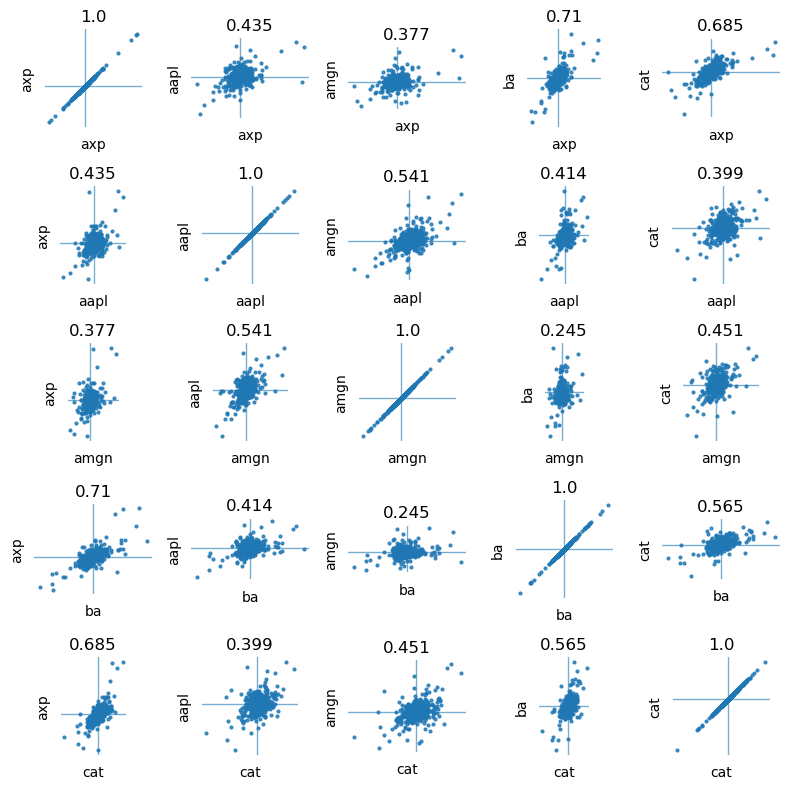

In [104]:
syms = prices.columns
N = len(syms)

fig, ax = plt.subplots(N, N, figsize=(8, 8))
for i in range(0, N):
    for j in range(0, N):
        ax[i, j].plot(returns[syms[i]], returns[syms[j]], '.', ms=4, alpha=0.8)
        ax[i, j].axhline(0, lw=1, alpha=0.6)
        ax[i, j].axvline(0, lw=1, alpha=0.6)
        ax[i, j].axes.spines['top'].set_visible(False)
        ax[i, j].axes.spines['right'].set_visible(False)
        ax[i, j].axes.spines['bottom'].set_visible(False)
        ax[i, j].axes.spines['left'].set_visible(False)
        ax[i, j].axes.get_xaxis().set_ticks([])
        ax[i, j].axes.get_yaxis().set_ticks([])
        ax[i, j].set_xlabel(syms[i])
        ax[i, j].set_ylabel(syms[j])
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(str(round(rho[syms[i]][syms[j]], 3)))
plt.tight_layout()

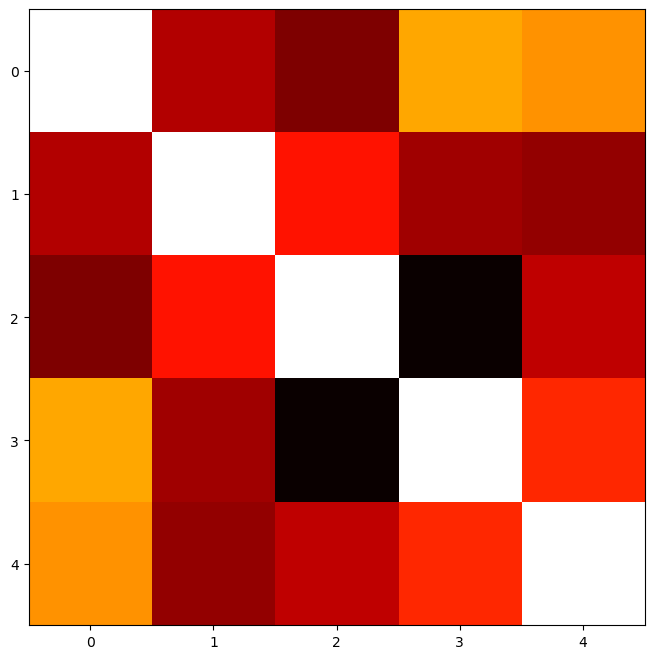

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(rho, cmap='hot', interpolation='nearest')

# Return versus Volatility

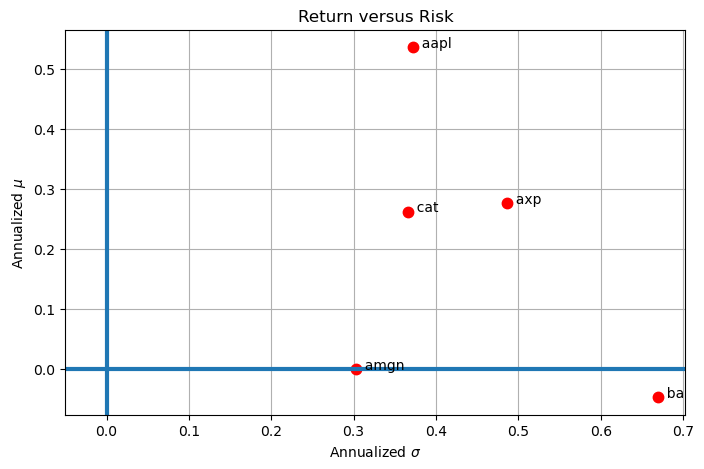

In [106]:
plt.figure(figsize=(8, 5))
for s in returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*sigma[s], 252*mu[s], 'r.', ms=15)
    plt.text(np.sqrt(252.0)*sigma[s], 252*mu[s], f"  {s:5<s}")

plt.axhline(0, lw=3)
plt.axvline(0, lw=3)
plt.xlim(-0.05, plt.xlim()[1])
plt.title('Return versus Risk')
plt.xlabel('Annualized $\sigma$')
plt.ylabel('Annualized $\mu$')
plt.grid(True)

## Creating Portfolios

A portfolio is created by allocating current wealth among a collection of assets. Let $w_n$ be the fraction of wealth allocated to the $n^{th}$ asset from a set of $N$ assets. Then

$$\sum_{n=1}^N w_n = 1$$

It may be possible to borrow assets, in which case the corresponding $w_n$ is negative. A _long only_ portfolio is one such that all of weights $w_n$ are greater than or equal to zero.

### Mean Return and Variance of a Portfolio

Denoting the total value of the portfolio as V, the value invested in asset $n$ is $w_nV$. At a price $S_n$, the number of units of the asset is $\frac{w_nV}{S_n}$ for a total value

$$ V = \sum_{n=1}^N \frac{w_n V}{S_n}S_n $$

at the start of the investment period. The value of the investment at the end of the period, $V'$, is given by

$$ V' = \sum_{n=1}^N \frac{w_n V}{S_n}(1+r^{lin}_n)S_n $$

Taking differences we find

$$ V' - V = \sum_{n=1}^N \frac{w_n V}{S_n}r^{lin}_nS_n $$

which, after division, yields the return on the portfolio

$$ r^{lin}_p = \frac{V'-V}{V} = \sum_{n=1}^N w_nr^{lin}_n $$

Taking expectations, the mean return of the portfolio

$$\boxed{\bar{r}^{lin}_{p} = \sum_{n=1}^N w_n \bar{r}^{lin}_n}$$

Variance of portfolio return

$$\boxed{\sigma_{p}^2 = \sum_{m=1}^N\sum_{n=1}^N w_m w_n \sigma_{mn}}$$

## Examples of Portfolios with Two Assets

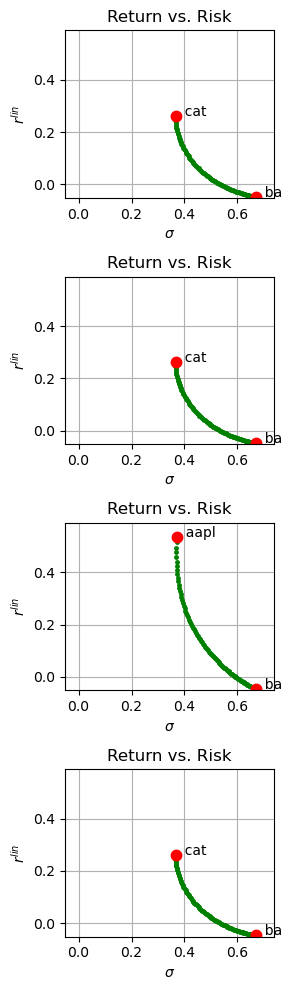

In [107]:
N_examples = 4

fig, ax = plt.subplots(N_examples, 1, figsize=(3, 10))

for i in range(0, N_examples):
    a, b = random.sample(prices.columns.values.tolist(), 2)

    for w in np.linspace(0.0, 1.0, 100):
        V = w*prices[a] + (1-w)*prices[b]
        rV = (V.diff()/V.shift(1)) 
        ax[i].plot(np.sqrt(252.0)*rV.std(), 252*rV.mean(),'g.', ms=5)
            
    for s in (a, b):    
        ax[i].plot(np.sqrt(252.0)*sigma[s], 252*mu[s], 'r.', ms=15)
        ax[i].text(np.sqrt(252.0)*sigma[s], 252*mu[s], "  {0:5<s}".format(s))

    ax[i].set_xlim(-0.05, 1.1*np.sqrt(252.0)*sigma.max())
    ax[i].set_ylim(1.1*252.0*mu.min(), 1.1*252.0*mu.max())

    ax[i].set_title('Return vs. Risk')
    ax[i].set_xlabel('$\sigma$')
    ax[i].set_ylabel('$r^{lin}$')
    ax[i].grid()

fig.tight_layout()

## Minimum Risk Portfolio

The minimum variance portfolio is found as a solution to 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1$$

### Pyomo Model and Solution

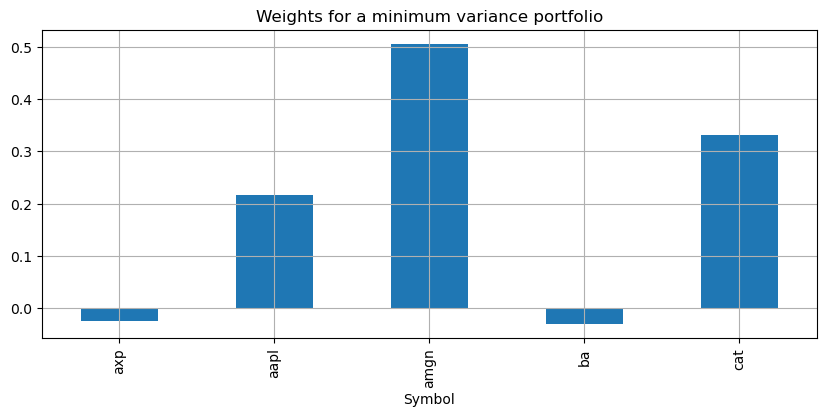

In [108]:
import pyomo.environ as pyo

# pyomo model
m = pyo.ConcreteModel()

# data
m.STOCKS = pyo.Set(initialize=returns.columns)

m.w = pyo.Var(m.STOCKS)

@m.Expression()
def portfolio_return(m):
    return sum(m.w[i] * mu[i] for i in m.STOCKS)

@m.Expression()
def portfolio_variance(m):
    return sum(m.w[i] * cov.loc[i, j] * m.w[j] for i in m.STOCKS for j in m.STOCKS)

@m.Objective(sense=pyo.minimize)
def minimum_variance(m):
    return m.portfolio_variance

@m.Constraint()
def weights(m):
    return sum(m.w[i] for i in m.STOCKS) == 1

# solve
pyo. SolverFactory('ipopt').solve(m)

# display solutions
w = pd.Series([m.w[i]() for i in m.STOCKS], m.STOCKS)

w.plot(kind='bar', figsize=(10, 4))
plt.xlabel('Symbol')
plt.title('Weights for a minimum variance portfolio')
plt.grid()

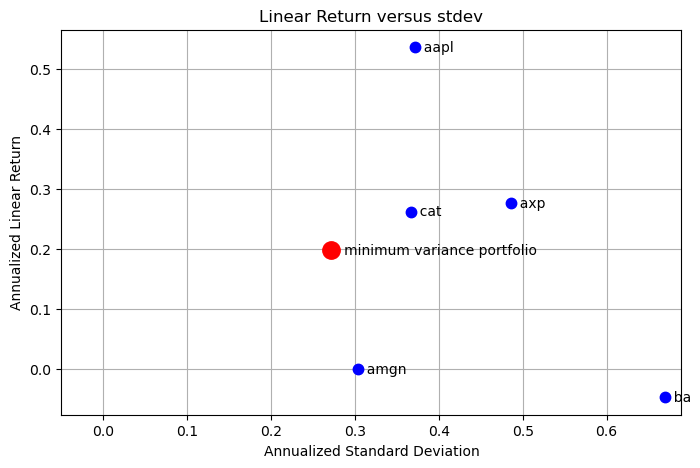

In [109]:
plt.figure(figsize=(8, 5))
for s in m.STOCKS:
    plt.plot(np.sqrt(252.0)*sigma[s], 252*mu[s], 'b.', ms=15)
    plt.text(np.sqrt(252.0)*sigma[s], 252*mu[s], "  {0:5<s}".format(s), va="center")

plt.plot(np.sqrt(252.0)*np.sqrt(m.portfolio_variance()), 252*m.portfolio_return(),
         'r.', ms=25)
plt.text(np.sqrt(252.0)*np.sqrt(m.portfolio_variance()), 252*m.portfolio_return(), 
         f"   minimum variance portfolio", va="center")
 
plt.xlim(-0.05, plt.xlim()[1])
plt.title('Linear Return versus stdev')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Linear Return')
plt.grid(True)

### Out-of-Sample Testing

Let's test the performance of the minimum variance portfolio using out-of-sample price data.

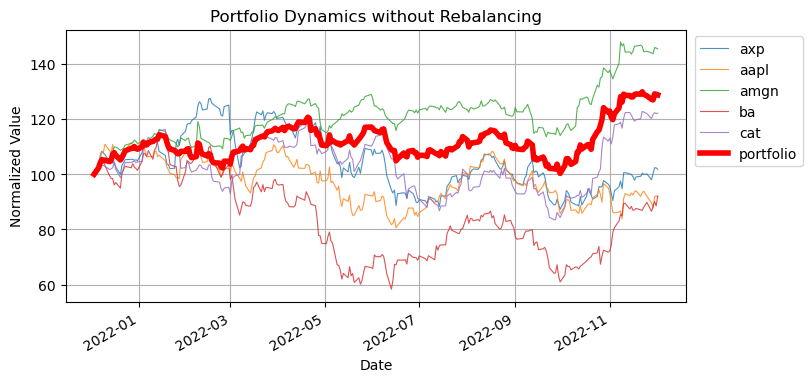

In [110]:
# simulate portfolio of 100 units of currency
V = pd.Series(0, index=prices_test.index)
for s in m.STOCKS:
    V += (100.0*float(m.w[s]())/prices_test[s][0])*prices_test[s]
     
# plot reference stocks
for s in m.STOCKS:
    pd.Series(100.0*prices_test[s]/prices_test[s][0]).plot(lw=0.8, alpha=0.8)
     
V.plot(lw=4, figsize=(8, 4) ,color='red', label="portfolio", 
       title="Portfolio Dynamics without Rebalancing", ylabel="Normalized Value", grid=True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

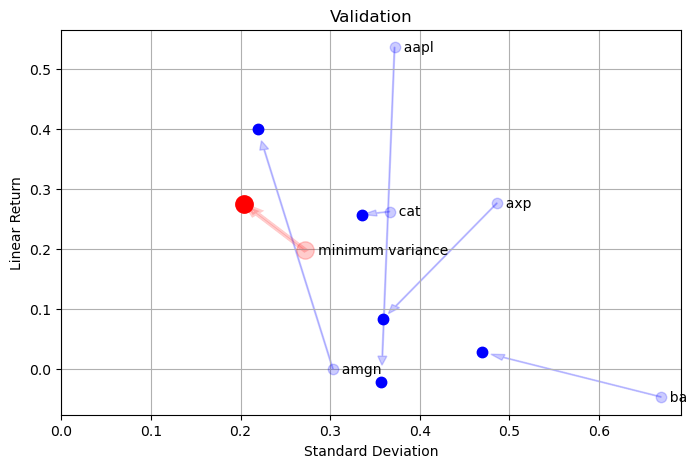

In [111]:
plt.figure(figsize=(8, 5))

returns_test = prices_test.diff()/prices_test.shift(1)
mu_test = returns_test.mean()
sigma_test = returns_test.std()

# plot stock components
for s in returns.columns:
    x = np.sqrt(252.0)*sigma[s]
    dx = np.sqrt(252.0)*(sigma_test[s] - sigma[s])
    y = 252.0*mu[s]
    dy = 252.0*(mu_test[s] - mu[s])
    
    plt.plot(x, y, 'b.', ms=15, alpha=0.2)
    plt.text(x, y, f"  {s:5<s}", va="center")
    
    plt.arrow(x, y, 0.95*dx, 0.95*dy, length_includes_head=True, head_width=0.01, color='b', alpha=0.2)
    plt.plot(x + dx, y + dy, 'b.', ms=15)

plt.xlim(0.0,plt.xlim()[1])
plt.title('Validation')
plt.xlabel('Standard Deviation')
plt.ylabel('Linear Return')
plt.grid(True)

x = np.sqrt(252.0)*np.sqrt(m.portfolio_variance())
y = 252*m.portfolio_return()
plt.plot(x, y, 'r.', ms=25, alpha=0.2)
plt.text(x, y, f"   minimum variance", va="center")

ReturnsV = (V.diff()/V.shift(1))
rlinMinVar = ReturnsV.mean()
stdevMinVar = ReturnsV.std()

dx = np.sqrt(252.0)*stdevMinVar - x
dy = 252.0*rlinMinVar - y

plt.plot(x + dx, y + dy, 'r.', ms=25)
plt.arrow(x, y, 0.95*dx, 0.95*dy, length_includes_head=True, head_width=0.01, color='r', lw=3, alpha=0.2)


## Markowitz Portfolio

The minimum variance portfolio does a good job of handling volatility, but at the expense of relatively low return. The Markowitz portfolio adds an additional constraint to specify mean portfolio return. 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1$$
and
$$\sum_{n=1}^N w_n \bar{r}^{lin}_n = \bar{r}^{lin}_p$$
By programming the solution of the optimization problem as a function of $\bar{r}_p$, it is possible to create a risk-return tradeoff curve.

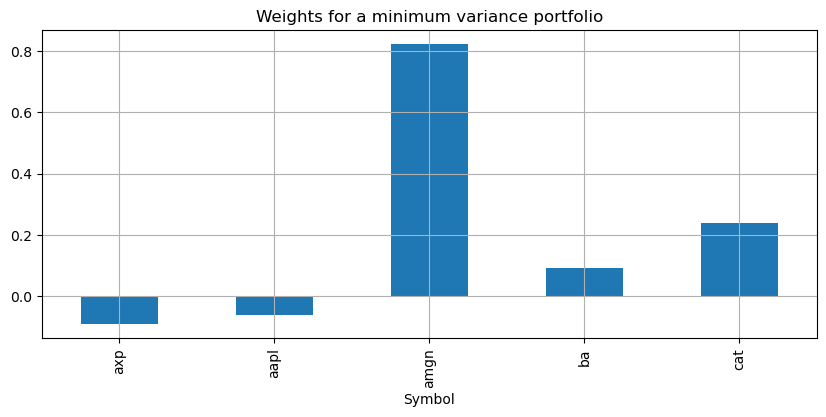

In [127]:
import pyomo.environ as pyo

def markowitz_model(returns, cov, rp=None):
    
    m = pyo.ConcreteModel()
    
    m.rp = pyo.Param(initialize=rp, mutable=True)

    m.STOCKS = pyo.Set(initialize=returns.columns)
    m.w = pyo.Var(m.STOCKS)

    @m.Expression()
    def portfolio_return(m):
        return sum(m.w[i] * mu[i] for i in m.STOCKS)

    @m.Expression()
    def portfolio_variance(m):
        return sum(m.w[i] * cov.loc[i, j] * m.w[j] for i in m.STOCKS for j in m.STOCKS)

    @m.Objective(sense=pyo.minimize)
    def minimum_variance(m):
        return m.portfolio_variance

    @m.Constraint()
    def weights(m):
        return sum(m.w[i] for i in m.STOCKS) == 1
    
    @m.Constraint()
    def ma(m):
        if m.rp is not None:
            return m.portfolio_return == m.rp
        else:
            return pyo.Constraint.Skip

    # solve
    pyo. SolverFactory('ipopt').solve(m)

    return(m)

m = markowitz_model(returns, cov, 0.0/252)
w = pd.Series([m.w[i]() for i in m.STOCKS], m.STOCKS)
w.plot(kind='bar', figsize=(10, 4))
plt.xlabel('Symbol')
plt.title('Weights for a minimum variance portfolio')
plt.grid()

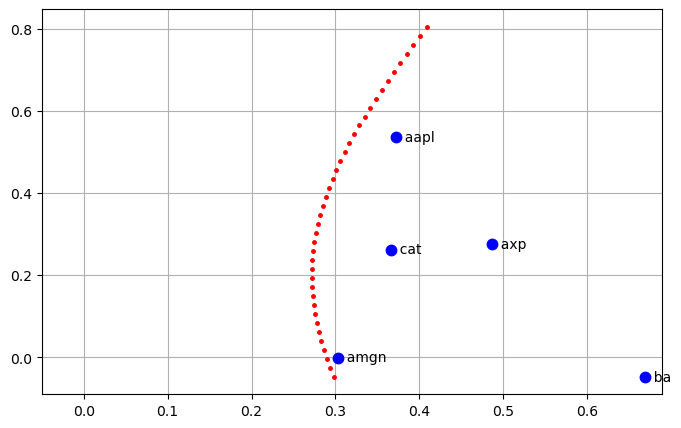

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for s in m.STOCKS:
    ax.plot(np.sqrt(252.0)*sigma[s], 252*mu[s], 'b.', ms=15)
    ax.text(np.sqrt(252.0)*sigma[s], 252*mu[s], "  {0:5<s}".format(s), va="center")

m = markowitz_model(returns, cov, 0/252)
solver = pyo.SolverFactory('ipopt')

# scan solution as function of portfolio return
for rp in np.linspace(min(0, mu.min()), 1.5*mu.max(), 40):
    m.rp.value = rp
    solver.solve(m)
    x = np.sqrt(252 * m.portfolio_variance())
    y = 252 * m.portfolio_return()
    ax.plot(x, y, 'r.', ms=5)
    
ax.set_xlim(-0.05, )
ax.grid(True)

## Markowitz Portfolio without Shorting

At this point there are no constraints on portfolio weights $w_1, w_2, \ldots, w_N$ other than they must sum to one. It is possible for the solution to the minimum variance or Markowitz portfolio problems to include negative weights, or weights greater than one. A negative weight corresponds to short selling an asset within the portfolio. A weight greater than one implies that short selling has taken place and the proceeds used to buy a stake in another asset that is greater in value than the portfolio. These are aggressive investment strategies.

A common constraint on operators or investors will accept short selling as a business strategy.

The minimum variance portfolio does a good job of handling volatility, but at the expense of relatively low return. The Markowitz portfolio adds an additional constraint to specify mean portfolio return. 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1$$
and
$$\sum_{n=1}^N w_n \bar{r}^{lin}_n = \bar{r}^{lin}_p$$
By programming the solution of the optimization problem as a function of $\bar{r}_p$, it is possible to create a risk-return tradeoff curve.

## Risk-Free Asset

The minimum variance portfolio does a good job of handling volatility, but at the expense of relatively low return. The Markowitz portfolio adds an additional constraint to specify mean portfolio return. 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1 - w_f$$
and
$$\sum_{n=1}^N w_n \bar{r}^{lin}_n + w_f r_f = \bar{r}^{lin}_p$$
By programming the solution of the optimization problem as a function of $\bar{r}_p$, it is possible to create a risk-return tradeoff curve.

In [54]:
# cvxpy problem description

m = ConcreteModel()

m.w = Var(range(0,N), domain = Reals)
wf

0.319026600441
0.01
0.110681042214


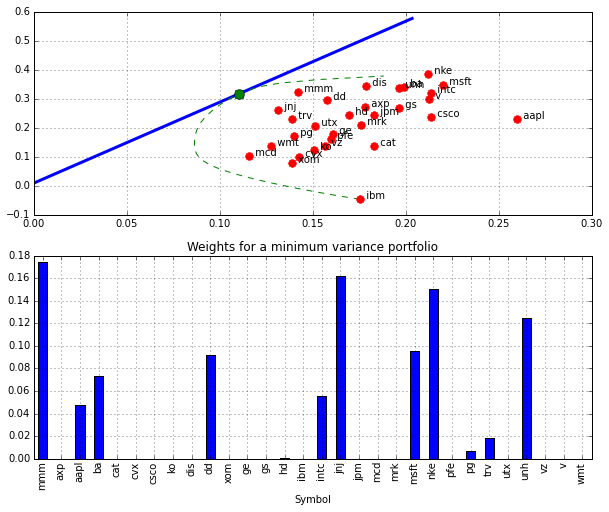

In [107]:
w = cvx.Variable(N)
wf = cvx.Variable(1)
r = cvx.Parameter()

rf = 0.01/252.0

risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum_entries(w) == 1 - wf, 
                np.array(rlin).T*w + wf*rf == r,
               w >= 0])

# lists to store results of parameter scans
r_data_rf = []
stdev_data_rf = []
w_data_rf = []

# scan solution as function of portfolio return
for rp in np.linspace(np.min(rf,rlin.min()),1.5*rlin.max(),100):
    r.value = rp
    s = prob.solve()
    if prob.status == "optimal":
        r_data_rf.append(rp)
        stdev_data_rf.append(np.sqrt(prob.solve()))
        w_data_rf.append([u[0,0] for u in w.value])

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(np.sqrt(252.0)*np.array(stdev_data_rf), 252.0*np.array(r_data_rf),lw=3)
plt.plot(np.sqrt(252.0)*np.array(stdev_data), 252.0*np.array(r_data),'g--')
for s in syms:
    plt.plot(np.sqrt(252.0)*stdev[s],252.0*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252.0*rlin[s],"  {0:5<s}".format(s))
    
# find max Sharpe ratio
k = np.argmax(np.divide(np.array(r_data)-rf,np.array(stdev_data)))
smax = stdev_data[k]
rmax = r_data[k]
plt.plot(np.sqrt(252.0)*smax,252.0*rmax,'o',ms=10)
print 252.0*rmax
print 252.0*rf
print np.sqrt(252.0)*smax

plt.xlim(0.0,plt.xlim()[1])
plt.grid()

plt.subplot(212)

wval = pd.Series(w_data[k],syms)
wval.plot(kind='bar')

plt.xlabel('Symbol')
plt.title('Weights for a minimum variance portfolio')
plt.grid()

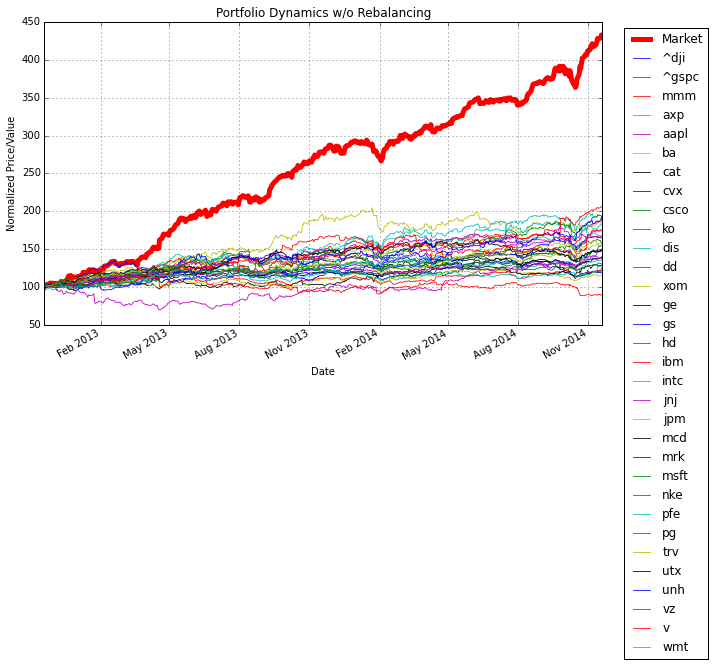

In [85]:
N = len(Prices.columns.values.tolist())

# create price history of the portfolio
V = pd.Series(0,index=Prices.index,name='Market')
for s in Prices.columns.values.tolist():
    V += (100.0*float(wval[s])/Prices[s][0])*Prices[s]
    
V.plot(lw=5,figsize=(10,6),color='red')

# plot components
plt.hold(True)
for s in Prices.columns.values.tolist():
    S = pd.Series(100.0*Prices[s]/Prices[s][0])
    S.plot(lw=0.8)

plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.title('Portfolio Dynamics w/o Rebalancing')
plt.ylabel('Normalized Price/Value')
plt.grid()

In [86]:
P['Market'] = V
Sigma = P.cov()
Sigma.ix[:,'Market']/Sigma.ix['Market','Market']

^dji     12.528858
^gspc     1.934181
mmm       0.197222
axp       0.120742
aapl      0.133096
ba        0.208771
cat       0.072742
cvx       0.051164
csco      0.016654
ko        0.016795
dis       0.136692
dd        0.086136
xom       0.053090
ge        0.020513
gs        0.154648
hd        0.086056
ibm      -0.047416
intc      0.046451
jnj       0.122271
jpm       0.054673
mcd       0.023521
mrk       0.067638
msft      0.068685
nke       0.121157
pfe       0.016580
pg        0.048426
trv       0.075682
utx       0.104676
unh       0.123136
vz        0.022144
v         0.065840
wmt       0.029284
Market    1.000000
Name: Market, dtype: float64

## Maximum Log Return (to be developed).

infeasible


IndexError: too many indices for array

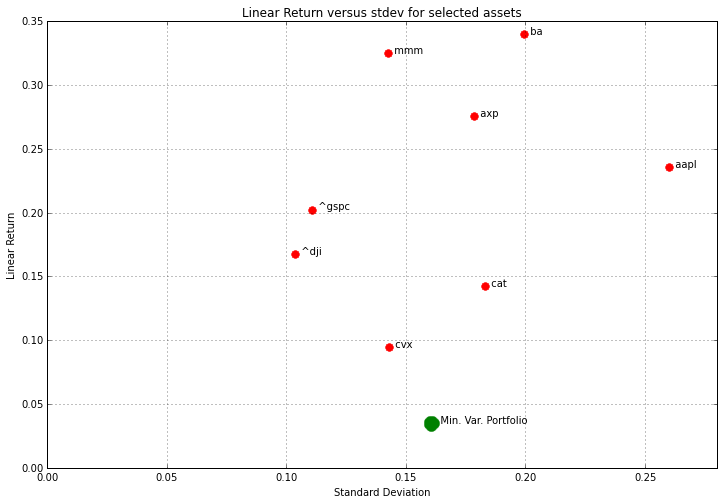

In [353]:
import cvxpy as cvx

N = len(syms)

w = cvx.Variable(N)
risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Maximize(np.array(rlin).T*w-0.5*risk), 
               [cvx.sum_entries(w) == 1,
                risk <= 0.0005/np.sqrt(252.0),
                w>=0])

prob.solve()
print prob.status

plt.figure(figsize=(12,8))
for s in Returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev for selected assets')
plt.xlabel('Standard Deviation')
plt.ylabel('Linear Return')
plt.grid()
plt.hold(True)

plt.plot(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'   Min. Var. Portfolio')

wval = np.array(w.value)[:,0].T
rlog = np.dot(np.array(rlin).T,wval)
stdevlog = np.sqrt(np.dot(np.dot(wval,np.array(sigma)),wval))

plt.plot(np.sqrt(252.0)*stdevlog,252.0*rlog,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevlog,252.0*rlog,'  Max. Return Portfolio')


## Exercises

1. Modify the minimum variance portfolio to be 'long-only', and add a diversification constraints that no more than 20% of the portfolio can be invested in any single asset.  How much does this change the annualized return?  the annualized standard deviation?

2. Modify the Markowitz portfolio to allow long-only positions and a diversification constraint that no more than 20% of the portfolio can be invested in any single asset. What conclusion to you draw?